<a href="https://colab.research.google.com/github/Mathiassule/Machine-Learning/blob/main/RNN_and_LSTM_Timeseries_Analysis_on_Stock_Exchange_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM

# Load the dataset
stockdata = pd.read_csv('stock_exchange.csv')

# Prepare the data for plotting - assuming 'CloseUSD' is the column to plot
data = stockdata.set_index('Date')['CloseUSD']
data.index = pd.to_datetime(data.index) # Convert index to datetime objects

data.sample(5)

,CloseUSD
Date,
1997-04-23,1227.140015
2003-10-13,223.945273
2005-02-18,5318.553662
1980-01-16,676.190002
2015-08-17,84.772998


### Visualize Dataset

In [ ]:
stockdata['Index'].unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'], dtype=object)

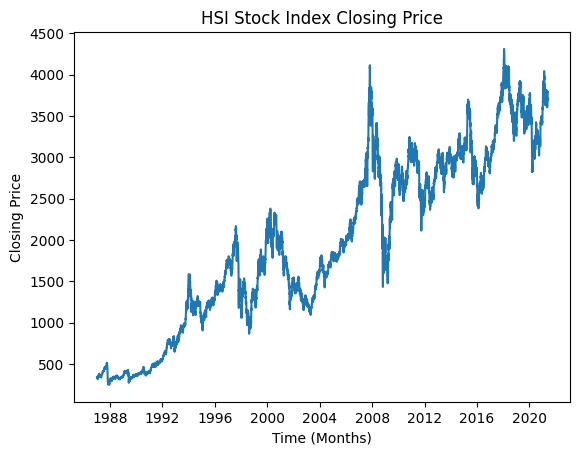

In [ ]:
# Select a single stock index (e.g., 'HSI')
hsi_data = stockdata[stockdata['Index'] == 'HSI'].set_index('Date')['CloseUSD']
hsi_data.index = pd.to_datetime(hsi_data.index)

# Plot the data for the selected index
plt.plot(hsi_data)
plt.title('HSI Stock Index Closing Price')
plt.xlabel('Time (Months)')
plt.ylabel('Closing Price')
plt.show()

## Preprocess the data

In [ ]:
# Preprocessing the data
# Normalize the dataset (MinMaxScaler scales the data to the range [0,1])
data = pd.DataFrame(hsi_data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences from the dataset
def create_sequences(data, time_step):
  x, y = [], []
  for i in range(len(data) - time_step):
    x.append(data[i:(i + time_step), 0])
    y.append(data[i + time_step, 0])
  return np.array(x), np.array(y)

# Set time step (number of months to use for prediction)
time_step = 12
X, y = create_sequences(scaled_data, time_step)

# Reshape input to be [samples, time_steps, features] which is required by RNN
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
X.shape

(8480, 12, 1)

## Creating train and test sets

In [ ]:
# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Build Recurrent Neural Network Model

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, return_sequences=False, input_shape=(time_step, 1))) # SimpleRNN layer with 50 units
model.add(Dense(1)) # Output layer to predict one value (the closing price)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 50
batch_size = 16

print('Training the model...')
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test data
print('Evaluating the model on the test set...')
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the model...
Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0148 - val_loss: 3.6088e-04
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.6791e-04 - val_loss: 3.1026e-04
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3058e-04 - val_loss: 1.9449e-04
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1507e-04 - val_loss: 0.0016
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2412e-04 - val_loss: 1.5569e-04
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0511e-04 - val_loss: 2.0155e-04
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0016e-04 - val_loss: 3.7951e-04
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.3481e-05 - val_loss: 1.1956e-04
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.1877e-05 - val_loss: 1.1974e-04
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.3132e-05 - val_loss: 1.8454e-04
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 6

## Predict futre values using the test set

In [ ]:
predicted_test = model.predict(X_test)

# Inverse transform the predicted values back to the original scale
predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Inverse transform the training set to its values
train_data_plot = scaler.inverse_transform(scaled_data[:train_size])

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Visualize train, test and predicted data

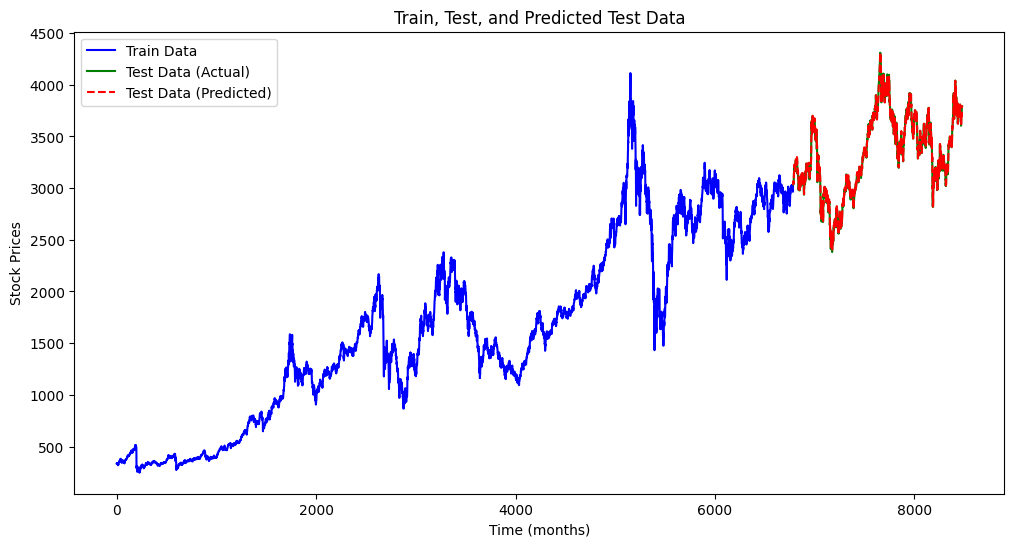

In [ ]:
# Prepare indexes to plot correctly
train_index = np.arange(0, len(train_data_plot))
test_index = np.arange(len(train_data_plot), len(train_data_plot) + len(y_test_actual))

# Plot the train set, test set, and predicted test set
plt.figure(figsize=(12, 6))
plt.plot(train_index, train_data_plot, label='Train Data', color='blue')
plt.plot(test_index, y_test_actual, label='Test Data (Actual)', color='green')
plt.plot(test_index, predicted_test, label='Test Data (Predicted)', color='red', linestyle='dashed')
plt.xlabel('Time (months)')
plt.ylabel('Stock Prices')
plt.title('Train, Test, and Predicted Test Data')
plt.legend()
plt.show()

## Let's check for overfitting

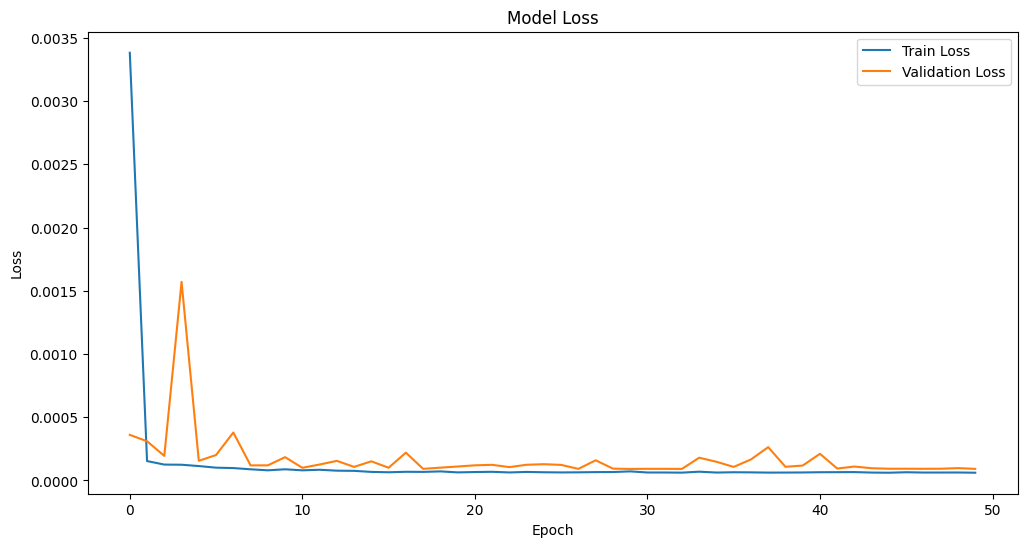

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Now lets Predict our dataset using LSTM (Long Short-Term Memory)

In [ ]:
# Build the RNN model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))  # LSTM layer with 50 units
model.add(Dense(1))  # Output layer to predict one value (the number of passengers)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 50
batch_size = 16

print("Training the model...")
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test data
print("Evaluating the model on the test set...")
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

Training the model...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0043 - val_loss: 3.7895e-04
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.8573e-04 - val_loss: 2.9517e-04
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7915e-04 - val_loss: 3.9765e-04
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.5227e-04 - val_loss: 2.1583e-04
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.4867e-04 - val_loss: 3.2484e-04
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3689e-04 - val_loss: 4.5623e-04
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.4139e-04 - val_loss: 2.4317e-04
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0634e-04 - val_loss: 2.3365e-04
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.9685e-05 - val_loss: 1.3884e-04
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 9.5532e-05 - val_loss: 1.9779e-04
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 8.9282e-05 - 

In [ ]:
# Predict future values using the test set
predicted_test = model.predict(X_test)

# Inverse transform the predicted values back to the original scale
predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Inverse transform the training set to its original values
train_data_plot = scaler.inverse_transform(scaled_data[:train_size])

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


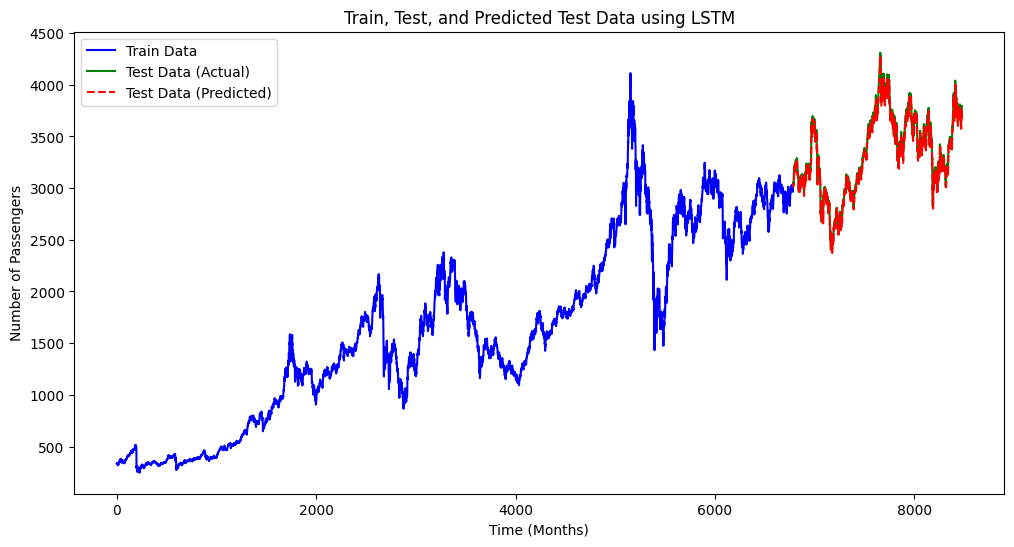

In [ ]:
# Prepare indexes to plot correctly
train_index = np.arange(0, len(train_data_plot))
test_index = np.arange(len(train_data_plot), len(train_data_plot) + len(y_test_actual))

# Plot the train set, test set, and predicted test set
plt.figure(figsize=(12, 6))
plt.plot(train_index, train_data_plot, label='Train Data', color='blue')
plt.plot(test_index, y_test_actual, label='Test Data (Actual)', color='green')
plt.plot(test_index, predicted_test, label='Test Data (Predicted)', color='red', linestyle='dashed')
plt.xlabel('Time (Months)')
plt.ylabel('Number of Passengers')
plt.title('Train, Test, and Predicted Test Data using LSTM')
plt.legend()
plt.show()

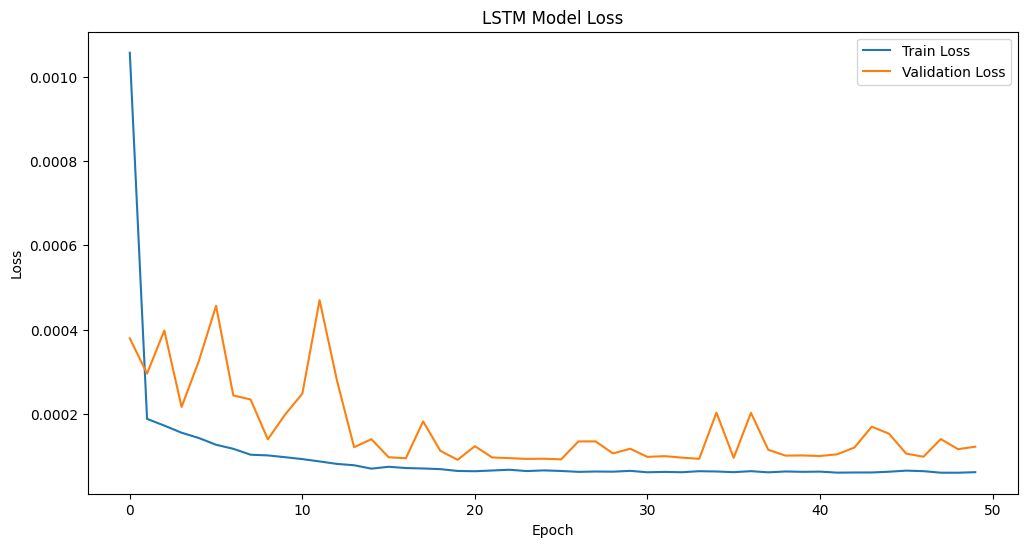

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()